# GEOG 498 - Unit 3 - Raster Based Analysis

This Python notebook perform spatial analysis on LiDAR point data and raster imagery to compare conifer encroachment between 2009 and 2022.

In [ ]:
#!pip install rasterstats

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import math
from shapely.geometry import Polygon, box
import requests
from rasterstats import zonal_stats
import json

In [43]:
# Get boundary of SEZ Assessment Units for Meeks Bay Meadow

resp = requests.get('https://maps.trpa.org/server/rest/services/SEZ_Assessment_Unit/FeatureServer/1/query?where=Assessment_Unit_Name+like+%27Meeks+Bay+meadow%25%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&defaultSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=243266910&havingClause=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=xyFootprint&resultOffset=&resultRecordCount=&returnTrueCurves=false&returnExceededLimitFeatures=false&quantizationParameters=&returnCentroid=false&timeReferenceUnknownClient=false&maxRecordCountFactor=&sqlFormat=none&resultType=&featureEncoding=esriDefault&datumTransformation=&cacheHint=false&f=geojson')

with open('sez_assessmnet_units.geojson', 'w') as f:
    f.write(resp.text)

sez_units = gpd.read_file('sez_assessmnet_units.geojson', driver='GeoJSON', crs=4326)
sez_units.to_crs(26910, inplace=True)
sez_units.head()

,OBJECTID,Acres,Assessment_Unit_Name,AquaticOrganismPassage_Barriers,AquaticOrganismPassage_DataSour,AquaticOrganismPassage_NumberOf,AquaticOrganismPassage_Rating,AquaticOrganismPassage_Score,AquaticOrganismPassage_StreamMi,Bank_Stability_Data_Source,...,Feature_Type,ConiferEncroachment_Comments,NDVI_ID,CountAttachments,AttachID,Threshold_Year,Shape__Area,Shape__Length,SEZ_ID,geometry
0,36,67.561870,Meeks Bay meadows - 3,0.0,"USFS / TRPA 2009, 2019",0.0,A,12.0,None,USFS,...,Meadow,large amounts of conifer encroachment occurrin...,TRPA_207,4,775,2019,273413.188254,2341.739458,36,"POLYGON ((747728.168 4323810.904, 747691.630 4..."
1,205,98.624574,Meeks Bay meadows - 1,0.0,"USFS / TRPA 2009, 2019",0.0,A,12.0,None,USFS,...,Meadow,large amounts of conifer encroachment occurrin...,TRPA_390,3,678,2019,399119.488814,2553.685299,205,"POLYGON ((748228.345 4324086.972, 748279.200 4..."
2,206,26.663075,Meeks Bay meadows - 4,NaN,"USFS / TRPA 2009, 2019",NaN,None,NaN,None,None,...,Meadow,not much change in conifer levels since 1940 b...,TRPA_392,1,676,2019,107901.638152,1600.900357,206,"POLYGON ((747664.456 4323437.823, 747670.439 4..."
3,207,52.346189,Meeks Bay meadows - 2,0.0,"USFS / TRPA 2009, 2019",0.0,A,12.0,None,USFS,...,Meadow,large amounts of conifer encroachment occurrin...,TRPA_391,4,677,2019,211837.512305,3186.794695,207,"POLYGON ((747728.168 4323810.904, 747724.283 4..."


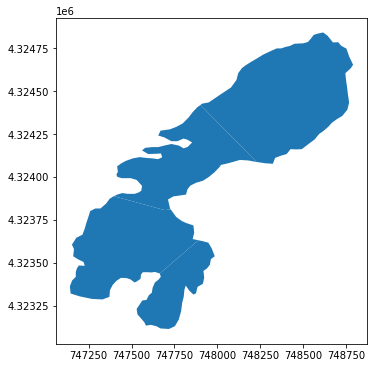

In [3]:
sez_units.plot(figsize=(10,6))
plt.show()

In [49]:
# Collect Object IDs for Trees in Meadow

# Get bounds of SEZ Assessment Units for Meeks Bay Meadow
bounds = sez_units.dissolve().bounds

# Build extent query parameter for ArcGIS Feature Service
extent = f"{bounds['minx'].min()},{bounds['miny'].min()},{bounds['maxx'].max()},{bounds['maxy'].max()}"

print('Extent:', extent)

# Retrieve feature ObjectIDs within Meeks Bay Meadow extent
resp = requests.get(f'https://maps.trpa.org/server/rest/services/Trees_in_Meadow/MapServer/0/query?where=MaxHt+%3C+6&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry={extent}&geometryType=esriGeometryEnvelope&inSR=6339&spatialRel=esriSpatialRelContains&distance=&units=esriSRUnit_Foot&relationParam=&outFields=OBJECTID%2CMaxHt&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&returnIdsOnly=true&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&sqlFormat=none&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson')

object_ids = json.loads(resp.text)['objectIds']

print('ObjectID count:', len(object_ids))

Extent: 747140.9486158856,4323114.742956466,748790.0141350613,4324841.090603694
ObjectID count: 18772


In [59]:
# Download GeoJSON data from ArcGIS MapServer 1000 features at a time.

sez_data = None

for idx in range(0, len(object_ids), 500):
    idx_plus = idx + 499
    if idx_plus > len(object_ids):
        idx_plus = len(object_ids) - 1

    print('Downloading', idx, idx_plus, object_ids[idx], object_ids[idx_plus])

    obj_list = ','.join([str(r) for r in object_ids[idx:idx_plus+1]])

    resp = requests.get(f'https://maps.trpa.org/server/rest/services/Trees_in_Meadow/MapServer/0/query?where=&text=&objectIds={obj_list}&time=&timeRelation=esriTimeRelationOverlaps&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelContains&distance=&units=esriSRUnit_Foot&relationParam=&outFields=OBJECTID%2CMaxHt&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&sqlFormat=none&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson')

    if sez_data is not None:
        data = gpd.read_file(resp.text)
        sez_data = pd.concat([sez_data, data])
    else:
        sez_data = gpd.read_file(resp.text)

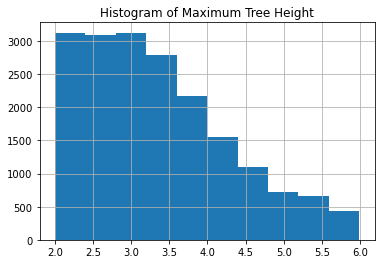

In [60]:
sez_data.hist('MaxHt')

plt.title('Histogram of Maximum Tree Height')
plt.show()

In [62]:
sez_data.count()

OBJECTID    18772
MaxHt       18772
geometry    18772
dtype: int64

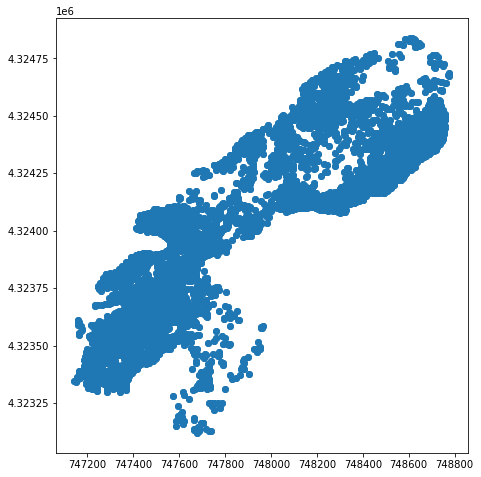

In [63]:
sez_data.to_crs(26910, inplace=True)

sez_data.plot(figsize=(10,8))
plt.show()

In [64]:
sez_data.to_file('sez_2009.geojson')

c:\Users\jorge\anaconda3\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [65]:
def create_grid(feature, shape, side_length, proj):
    '''Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.'''

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(20)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds


    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ["square", "rectangle", "box"]:

        # Adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):

            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y - side_length, max_y + side_length, side_length):

                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length))


    # Otherwise, create grid of hexagons
    elif shape == "hexagon":

        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values that will define column positions with vertical displacement
        for x in np.arange(min_x, max_x + x_step, x_step):

            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in np.arange(min_y, max_y + y_step, y_step):

                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:

                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, odd
            else:

                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem

            # Increase column number by 1
            column_number += 1

    # Else, raise error
    else:
        raise Exception("Specify a rectangle or hexagon as the grid shape.")

    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = proj)

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid

In [66]:
# Set side length for cells in grid
# This is dependent on projection chosen as length is in units specified in projection
side_length = 15 # meters in 26910 projection

# Set shape of grid
# shape = "hexagon"
shape = "rectangle"

# Set projection
proj = 26910

sez_grid = create_grid(feature = sez_data, shape = shape, side_length = side_length, proj=proj)

In [67]:
sez_grid.head()

,geometry,Grid_ID
0,"POLYGON ((747125.488 4323084.634, 747125.488 4...",0
1,"POLYGON ((747125.488 4323099.634, 747125.488 4...",1
2,"POLYGON ((747125.488 4323114.634, 747125.488 4...",2
3,"POLYGON ((747125.488 4323129.634, 747125.488 4...",3
4,"POLYGON ((747125.488 4323144.634, 747125.488 4...",4


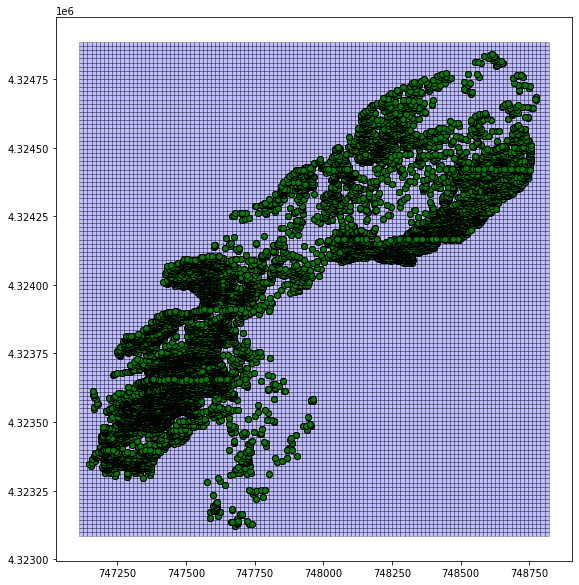

In [68]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

sez_grid.plot(
    ax=ax, color='blue', edgecolor='black', alpha=0.25
)

sez_data.plot(
    ax=ax, color='green', edgecolor='black'
)

plt.show()

In [69]:
sez_bin_data = sez_grid.sjoin(sez_data, how='left', predicate='intersects') \
    .groupby('Grid_ID') \
    .agg({'geometry':'first', 'OBJECTID':'count'})
sez_bin_data.rename(columns={'OBJECTID':'Encroachment_Count'}, inplace=True)
sez_bin_data['Encroachment_2009'] = sez_bin_data['Encroachment_Count'] > 0
sez_bin_data.drop(columns=['Encroachment_Count'], inplace=True)
sez_bin_data = gpd.GeoDataFrame(sez_bin_data, geometry=sez_bin_data.geometry, crs=26910)
sez_bin_data.reset_index(inplace=True)

sez_bin_data.head()

,Grid_ID,geometry,Encroachment_2009
0,0,"POLYGON ((747125.488 4323084.634, 747125.488 4...",False
1,1,"POLYGON ((747125.488 4323099.634, 747125.488 4...",False
2,2,"POLYGON ((747125.488 4323114.634, 747125.488 4...",False
3,3,"POLYGON ((747125.488 4323129.634, 747125.488 4...",False
4,4,"POLYGON ((747125.488 4323144.634, 747125.488 4...",False


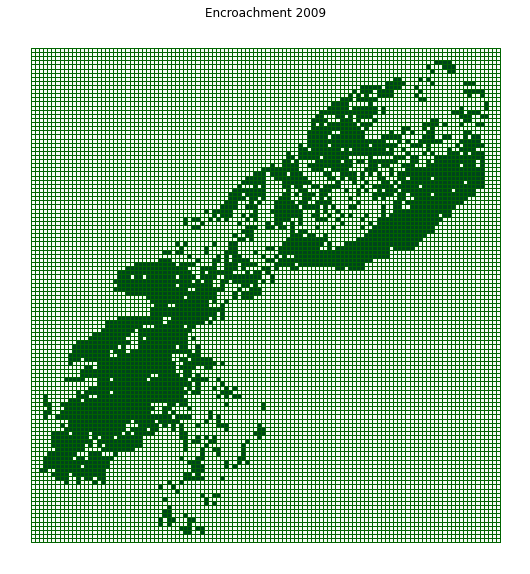

In [70]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.set_axis_off()
ax.set_title('Encroachment 2009')

sez_bin_data.plot(
    ax=ax, column='Encroachment_2009', 
    edgecolor='darkgreen', cmap='Greens'
)

plt.show()

In [71]:
# Compute zonal stats for grid area using 2022 Encroachment raster

sez_bin_data['mean'] = pd.DataFrame(
    zonal_stats(
        vectors=sez_bin_data['geometry'], 
        raster='USGS_SNB22_10SGJ_Canopy.tif', 
        stats='mean'
    )
)['mean']

sez_bin_data['Encroachment_2022'] = sez_bin_data['mean'].gt(-1) & sez_bin_data['mean'].lt(6)
sez_bin_data.drop(columns=['mean'], inplace=True)

In [72]:
sez_bin_data.head()

,Grid_ID,geometry,Encroachment_2009,Encroachment_2022
0,0,"POLYGON ((747125.488 4323084.634, 747125.488 4...",False,False
1,1,"POLYGON ((747125.488 4323099.634, 747125.488 4...",False,False
2,2,"POLYGON ((747125.488 4323114.634, 747125.488 4...",False,True
3,3,"POLYGON ((747125.488 4323129.634, 747125.488 4...",False,True
4,4,"POLYGON ((747125.488 4323144.634, 747125.488 4...",False,True


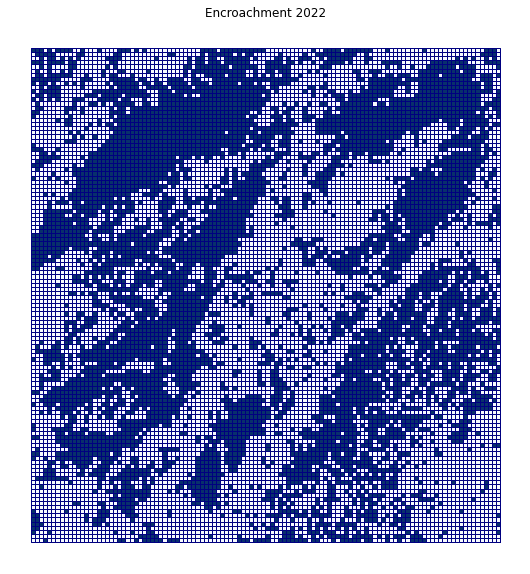

In [73]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.set_axis_off()
ax.set_title('Encroachment 2022')

sez_bin_data.plot(
    ax=ax, 
    column='Encroachment_2022', 
    edgecolor='navy', 
    cmap='Blues'
)

plt.show()

In [74]:
sez_grid.to_file('sez_grid.geojson', driver='GeoJSON')

c:\Users\jorge\anaconda3\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [75]:
sez_bin_data.to_file('sez_bin.geojson', driver='GeoJSON')

c:\Users\jorge\anaconda3\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Compare 2009 and 2022 conifer encroachment values.

In [76]:
def encroachment_change(d):
    val = None

    if d['Encroachment_2009'] == False and d['Encroachment_2022'] == False:
        val = 'No encroachment'
    elif d['Encroachment_2009'] == True and d['Encroachment_2022'] == False:
        val = 'Conifer retreat'
    elif d['Encroachment_2009'] == False and d['Encroachment_2022'] == True:
        val = 'New encroachment'
    elif d['Encroachment_2009'] == True and d['Encroachment_2022'] == True:
        val = 'Ongoing encroachment'
    
    return val

sez_bin_data['Change_In_Encroachment'] = sez_bin_data.apply(lambda d: encroachment_change(d), axis=1)

sez_bin_data.head()

,Grid_ID,geometry,Encroachment_2009,Encroachment_2022,Change_In_Encroachment
0,0,"POLYGON ((747125.488 4323084.634, 747125.488 4...",False,False,No encroachment
1,1,"POLYGON ((747125.488 4323099.634, 747125.488 4...",False,False,No encroachment
2,2,"POLYGON ((747125.488 4323114.634, 747125.488 4...",False,True,New encroachment
3,3,"POLYGON ((747125.488 4323129.634, 747125.488 4...",False,True,New encroachment
4,4,"POLYGON ((747125.488 4323144.634, 747125.488 4...",False,True,New encroachment


In [77]:
chart_data = sez_bin_data \
    .sjoin(sez_units, how='inner', predicate='within') \
    .groupby('Change_In_Encroachment') \
    .agg({'Grid_ID':'count'}) \
    .rename(columns={'Grid_ID':'Count'}) \
    .reset_index()

chart_data

,Change_In_Encroachment,Count
0,Conifer retreat,785
1,New encroachment,821
2,No encroachment,884
3,Ongoing encroachment,1512


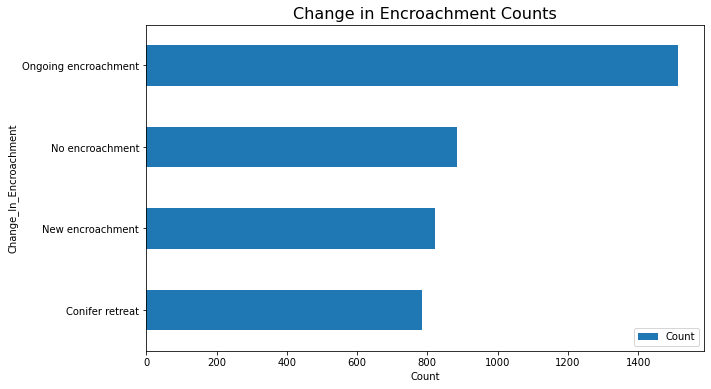

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.set_title('Change in Encroachment Counts', fontdict={'size':16})
ax.set_xlabel('Count')
ax.set_ylabel('Change Type')

chart_data.plot(kind='barh', ax=ax, x='Change_In_Encroachment', y='Count')

plt.show()

In [79]:
units = sez_units[['Assessment_Unit_Name', 'geometry']]

bin_data = sez_bin_data.sjoin(units, how='inner', predicate='within')
bin_data.head()

,Grid_ID,geometry,Encroachment_2009,Encroachment_2022,Change_In_Encroachment,index_right,Assessment_Unit_Name
376,376,"POLYGON ((747170.488 4323324.634, 747170.488 4...",False,True,New encroachment,0,Meeks Bay meadows - 3
377,377,"POLYGON ((747170.488 4323339.634, 747170.488 4...",True,True,Ongoing encroachment,0,Meeks Bay meadows - 3
378,378,"POLYGON ((747170.488 4323354.634, 747170.488 4...",True,False,Conifer retreat,0,Meeks Bay meadows - 3
379,379,"POLYGON ((747170.488 4323369.634, 747170.488 4...",True,False,Conifer retreat,0,Meeks Bay meadows - 3
496,496,"POLYGON ((747185.488 4323324.634, 747185.488 4...",False,True,New encroachment,0,Meeks Bay meadows - 3


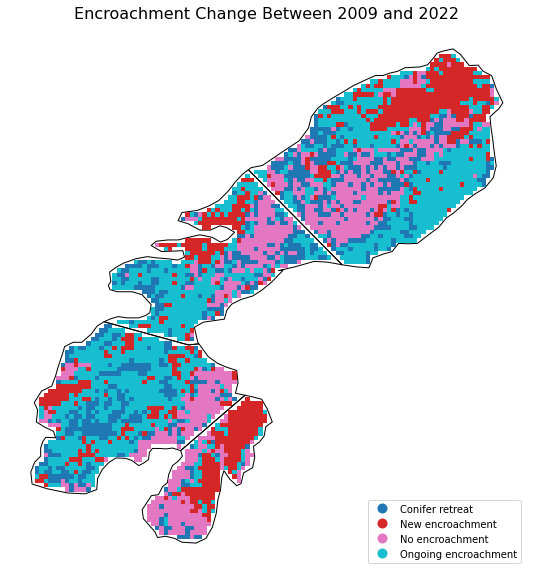

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.set_title('Encroachment Change Between 2009 and 2022', fontdict={'size':16})
ax.set_axis_off()

sez_units.plot(
    ax=ax,
    color='none',
    edgecolor='black'
)

bin_data.plot(
    ax=ax,
    column='Change_In_Encroachment',
    legend=True,
    legend_kwds={'loc': 'lower right'}
)

plt.show()

In [87]:
chart_data = bin_data.groupby(['Assessment_Unit_Name', 'Change_In_Encroachment']) \
    .agg({'Grid_ID':'count'}) \
    .rename(columns={'Grid_ID':'Count'})

chart_data = chart_data.pivot_table(
        index='Assessment_Unit_Name', 
        values='Count', 
        columns='Change_In_Encroachment') \
    .reset_index() \
    .fillna(0)

chart_data = chart_data[['Assessment_Unit_Name', 'No encroachment', 'Conifer retreat', 
                         'New encroachment', 'Ongoing encroachment']]
chart_data

Change_In_Encroachment,Assessment_Unit_Name,No encroachment,Conifer retreat,New encroachment,Ongoing encroachment
0,Meeks Bay meadows - 1,381,327,359,597
1,Meeks Bay meadows - 2,179,177,127,332
2,Meeks Bay meadows - 3,173,249,155,537
3,Meeks Bay meadows - 4,151,32,180,46


In [88]:
unit_sum = bin_data.groupby('Assessment_Unit_Name').agg({'Change_In_Encroachment':'count'}).reset_index()
unit_sum.rename(columns={'Change_In_Encroachment':'Total_Count'}, inplace=True)
unit_sum

,Assessment_Unit_Name,Total_Count
0,Meeks Bay meadows - 1,1664
1,Meeks Bay meadows - 2,815
2,Meeks Bay meadows - 3,1114
3,Meeks Bay meadows - 4,409


In [89]:
chart_data = chart_data.merge(
    unit_sum, 
    left_on='Assessment_Unit_Name', 
    right_on='Assessment_Unit_Name'
)

chart_data

,Assessment_Unit_Name,No encroachment,Conifer retreat,New encroachment,Ongoing encroachment,Total_Count
0,Meeks Bay meadows - 1,381,327,359,597,1664
1,Meeks Bay meadows - 2,179,177,127,332,815
2,Meeks Bay meadows - 3,173,249,155,537,1114
3,Meeks Bay meadows - 4,151,32,180,46,409


In [90]:
chart_data['No Encroachment'] = chart_data.apply(
    lambda d: "{:.0f} ({:.0f}%)".format(d['No encroachment'], round(d['No encroachment'] / d['Total_Count'] * 100, 0)),
    axis=1
)
chart_data['New Encroachment'] = chart_data.apply(
    lambda d: "{:.0f} ({:.0f}%)".format(d['New encroachment'], round(d['New encroachment'] / d['Total_Count'] * 100, 0)),
    axis=1
)
chart_data['Ongoing Encroachment'] = chart_data.apply(
    lambda d: "{:.0f} ({:.0f}%)".format(d['Ongoing encroachment'], round(d['Ongoing encroachment'] / d['Total_Count'] * 100, 0)),
    axis=1
)
chart_data['Conifer Retreat'] = chart_data.apply(
    lambda d: "{:.0f} ({:.0f}%)".format(d['Conifer retreat'], round(d['Conifer retreat'] / d['Total_Count'] * 100, 0)),
    axis=1
)

chart_data[['Assessment_Unit_Name', 'No Encroachment', 'Conifer Retreat', 'New Encroachment', 'Ongoing Encroachment']]

,Assessment_Unit_Name,No Encroachment,Conifer Retreat,New Encroachment,Ongoing Encroachment
0,Meeks Bay meadows - 1,381 (23%),327 (20%),359 (22%),597 (36%)
1,Meeks Bay meadows - 2,179 (22%),177 (22%),127 (16%),332 (41%)
2,Meeks Bay meadows - 3,173 (16%),249 (22%),155 (14%),537 (48%)
3,Meeks Bay meadows - 4,151 (37%),32 (8%),180 (44%),46 (11%)
